In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g4728e35f0d+53a8438ab4 	current w_2023_38 setup
alert_packet          g6041bd2d66 	current w_2023_38 setup
analysis_drp          g8a53795882+8240499edc 	current w_2023_38 setup
analysis_tools        g1887775915+c89e410209 	current w_2023_38 setup
ap_association        g6a6fcd37b7+f81e0a4cd9 	current w_2023_38 setup
ap_pipe               g06c608b3b8+0cce5f0898 	current w_2023_38 setup
ap_verify             gf37a9491f6+9462b9949d 	current w_2023_38 setup
astro_metadata_translator g0978aabd1f+0ce179faa8 	current w_2023_38 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_38 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_38 setup
cbp                   ga32fcf49c8+387721ca5c 	current w_2023_38 setup
cell_coadds           g9faf7ed3f3+8240499edc 	current w_2023_38 setup
coadd_utils           g337abbeb29+387721ca5c 	current w_2023_38 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

# Paths 

In [10]:
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'vertical_shift_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [13]:
obs_type = 'science'
obs_day = 20230926
physical_filter = 'empty~holo4_003' #Note that there are no exposure with this config for the moment 

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [15]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092600446
  physical_filter: 'empty~holo4_003'
  obs_id: 'AT_O_20230926_000446'
  exposure_time: 30.0
  dark_time: 30.2346
  observation_type: 'science'
  observation_reason: 'sitcom-1043'
  day_obs: 20230926
  seq_num: 446
  seq_start: 446
  seq_end: 446
  group_name: '2023-09-27T02:51:35.414'
  group_id: 2757126954140000
  target_name: 'HD2811'
  science_program: 'BLOCK-102'
  tracking_ra: 7.827800206545046
  tracking_dec: -43.60460268648411
  sky_angle: 19.097270869928906
  azimuth: 127.53812441035177
  zenith_angle: 27.05391872351369
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-27 02:54:18.911003', scale='tai', format='iso'), end=astropy.time.Time('2023-09-27 02:54:49.146000', scale='tai', format='iso'))
	 timespan:             [2023-09-27T02:54:18.911003, 2023-09-27T02:54:49.146000)
	 timespan.begin:       2023-09-27 02:54:18.911003
	 id:                   2023092600446
	 day_obs:              20230926
	 

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  68


In [17]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,exp_time,ra,dec,skyangle,science_program
63,2023092600512,AT_O_20230926_000512,20230926,512,2023-09-27 03:42:47.848997,2023-09-27 03:42:58.081,science,HD2811,empty~holo4_003,19.270444,10.0,7.829349,-43.603302,31.841295,BLOCK-102
64,2023092600513,AT_O_20230926_000513,20230926,513,2023-09-27 03:43:21.583998,2023-09-27 03:43:31.825,science,HD2811,empty~holo4_003,19.188712,10.0,7.830427,-43.602159,31.841293,BLOCK-102
65,2023092600514,AT_O_20230926_000514,20230926,514,2023-09-27 03:43:44.508999,2023-09-27 03:43:54.753,science,HD2811,empty~holo4_003,19.133679,10.0,7.830462,-43.602179,31.841334,BLOCK-102
66,2023092600515,AT_O_20230926_000515,20230926,515,2023-09-27 03:44:18.201997,2023-09-27 03:44:28.438,science,HD2811,empty~holo4_003,19.054660,10.0,7.831341,-43.600949,31.841343,BLOCK-102
67,2023092600516,AT_O_20230926_000516,20230926,516,2023-09-27 03:44:41.214988,2023-09-27 03:44:51.445,science,HD2811,empty~holo4_003,18.999954,10.0,7.831390,-43.600935,31.841309,BLOCK-102


Select exposures: 

In [18]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516]


In [19]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092600446 2023092600447 2023092600448 2023092600449 2023092600450
 2023092600451 2023092600452 2023092600453 2023092600454 2023092600455
 2023092600456 2023092600457 2023092600458 2023092600459 2023092600460
 2023092600461 2023092600462 2023092600463 2023092600464 2023092600465
 2023092600466 2023092600467 2023092600468 2023092600469 2023092600470
 2023092600471 2023092600472 2023092600473 2023092600474 2023092600475
 2023092600476 2023092600477 2023092600478 2023092600479 2023092600480
 2023092600481 2023092600485 2023092600486 2023092600487 2023092600488
 2023092600489 2023092600490 2023092600491 2023092600492 2023092600493
 2023092600494 2023092600495 2023092600496 2023092600497 2023092600498
 2023092600499 2023092600500 2023092600501 2023092600502 2023092600503
 2023092600504 2023092600505 2023092600506 2023092600507 2023092600508
 2023092600509 2023092600510 2023092600511 2023092600512 2023092600513
 2023092600514 2023092600515 2023092600516]


In [20]:
min_seq = 487
max_seq = 516

In [21]:
seq_mask = (seq_nums>=min_seq)*(seq_nums<=max_seq)

In [22]:
seq_nums = seq_nums[seq_mask]
ids = ids[seq_mask]

In [23]:
print(seq_nums)
print(ids)

[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516]
[2023092600487 2023092600488 2023092600489 2023092600490 2023092600491
 2023092600492 2023092600493 2023092600494 2023092600495 2023092600496
 2023092600497 2023092600498 2023092600499 2023092600500 2023092600501
 2023092600502 2023092600503 2023092600504 2023092600505 2023092600506
 2023092600507 2023092600508 2023092600509 2023092600510 2023092600511
 2023092600512 2023092600513 2023092600514 2023092600515 2023092600516]


We test retrieving one of them: 

In [200]:
seq_num0 = seq_nums[20]
exp_id0 = ids[20]
print(exp_id0)

2023092600507


In [201]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

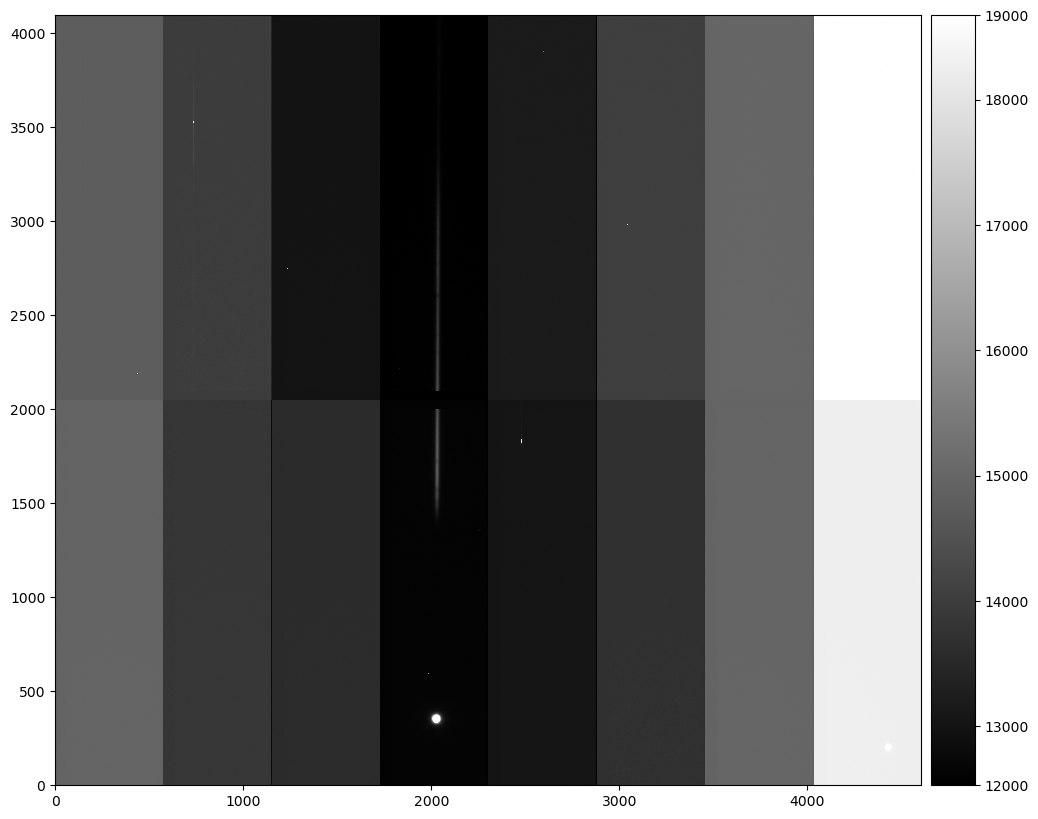

In [202]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

## Organize amplifiers 

In [203]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [204]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [205]:
# configuration
isr_config =  IsrTaskConfig()

In [206]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [207]:
isr_task = IsrTask(config=isr_config)

In [208]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [209]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [210]:
test_ = isr_test.exposure.image.array

Value range 

In [211]:
np.min(test_.flatten())

-77.40706

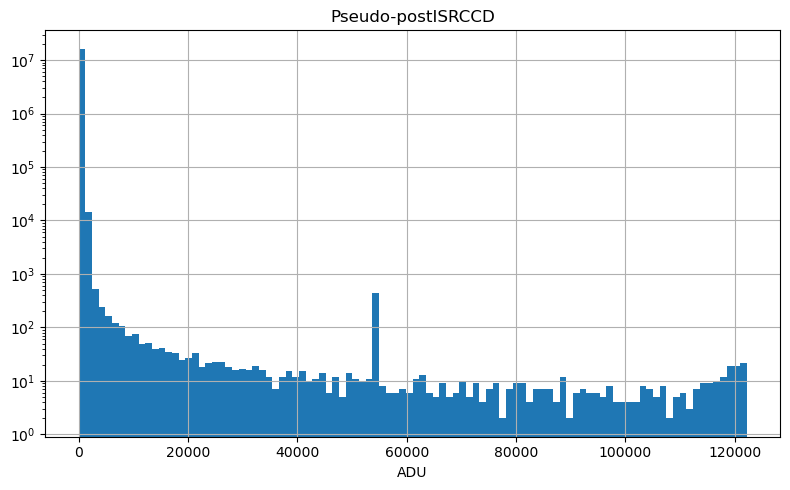

In [212]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

In [219]:
center_spec = 1750
#ylim_spec = 1280
xlim_spec0 = 1660
xlim_spec1 = 1850

delta_xlim = xlim_spec1-xlim_spec0

xlim_bck00 = 1320
xlim_bck01 = xlim_bck00+delta_xlim
xlim_bck10 = 2060
xlim_bck11 = xlim_bck10+delta_xlim

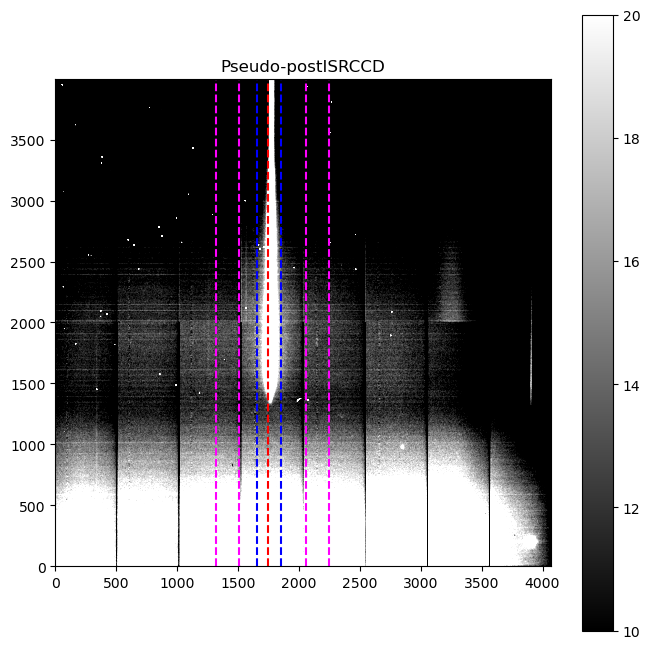

In [220]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=20)
#ax.axhline(y=ylim_spec,ls='--')
ax.axvline(x=center_spec,ls='--',color='r')
ax.axvline(x=xlim_spec0,ls='--',color='b')
ax.axvline(x=xlim_spec1,ls='--',color='b')
ax.axvline(x=xlim_bck00,ls='--',color='magenta')
ax.axvline(x=xlim_bck01,ls='--',color='magenta')
ax.axvline(x=xlim_bck10,ls='--',color='magenta')
ax.axvline(x=xlim_bck11,ls='--',color='magenta')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

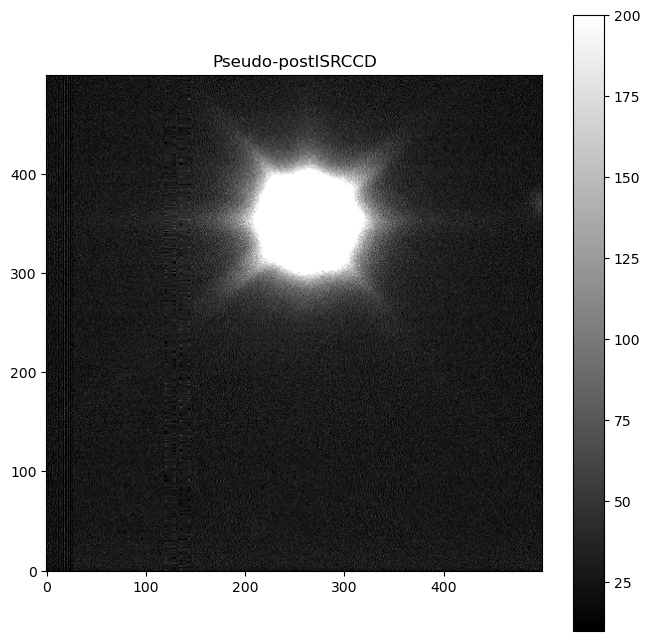

In [221]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_[0:500,1500:2000],cmap="gray",origin='lower',vmin=10,vmax=200)
#ax.axhline(y=ylim_spec,ls='--')
'''
ax.axvline(x=center_spec,ls='--',color='r')
ax.axvline(x=xlim_spec0,ls='--',color='b')
ax.axvline(x=xlim_spec1,ls='--',color='b')
ax.axvline(x=xlim_bck00,ls='--',color='magenta')
ax.axvline(x=xlim_bck01,ls='--',color='magenta')
ax.axvline(x=xlim_bck10,ls='--',color='magenta')
ax.axvline(x=xlim_bck11,ls='--',color='magenta')
'''
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [222]:
spec_line = test_[:,center_spec]
y_ = np.arange(len(spec_line))

zero_order = np.max(spec_line)
y_0order = y_[spec_line==zero_order][0]
ylim_spec0 = y_0order+1000
ylim_spec1 = ylim_spec0+700
ylim_spec2 = ylim_spec0+400

Text(0, 0.5, 'ADU')

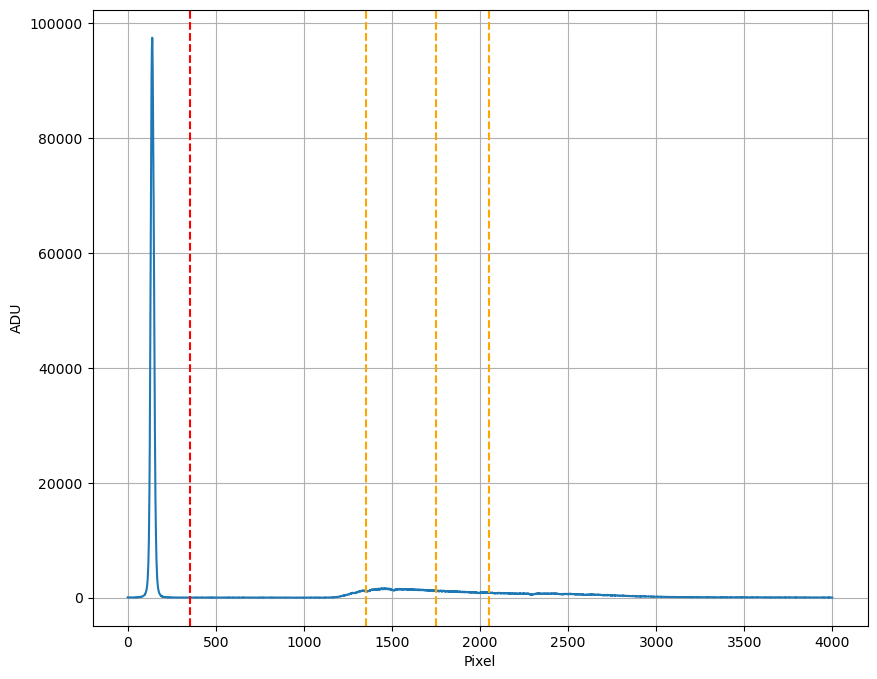

In [223]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(y_,spec_line_)
ax.axvline(x=y_0order,ls='--',color='r')
ax.axvline(x=ylim_spec0,ls='--',color='orange')
ax.axvline(x=ylim_spec1,ls='--',color='orange')
ax.axvline(x=ylim_spec2,ls='--',color='orange')
ax.grid()
ax.set_xlabel('Pixel')
ax.set_ylabel('ADU')

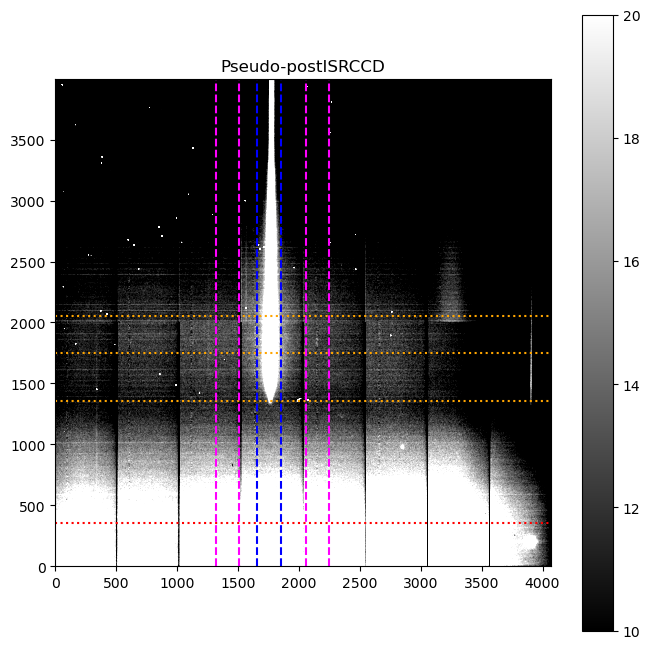

In [224]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=20)

ax.axhline(y=y_0order,ls=':',color='r')
ax.axhline(y=ylim_spec0,ls=':',color='orange')
ax.axhline(y=ylim_spec1,ls=':',color='orange')
ax.axhline(y=ylim_spec2,ls=':',color='orange')

ax.axvline(x=xlim_spec0,ls='--',color='b')
ax.axvline(x=xlim_spec1,ls='--',color='b')
ax.axvline(x=xlim_bck00,ls='--',color='magenta')
ax.axvline(x=xlim_bck01,ls='--',color='magenta')
ax.axvline(x=xlim_bck10,ls='--',color='magenta')
ax.axvline(x=xlim_bck11,ls='--',color='magenta')
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

In [231]:
filename_out = 'spec_{0}_{1}.fits'.format(exp_id0,physical_filter.replace('~','-'))

outdir_ = os.path.join(outdir_base,outdir_label.format(obs_day))
if os.path.exists(outdir_)==False:
    os.mkdir(outdir_)
fullfilename_out = os.path.join(outdir_,filename_out)

print(f">>>>  output filename {filename_out}")

md = test_img.getMetadata().toDict()

hdr = fits.Header()
    
for key,value in md.items():
    hdr[str(key)] = value
    

# Be carefull for Spectractor, 2 hdu units are necessary

primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(test_)

hdu_list = fits.HDUList([primary_hdu, image_hdu])

hdu_list.writeto(fullfilename_out,overwrite=True)

>>>>  output filename spec_2023092600507_empty-holo4_003.fits


In [97]:
int_spec_ = np.sum(test_[ylim_spec0:ylim_spec1,xlim_spec0:xlim_spec1])
int_bck0 = np.sum(test_[ylim_spec0:ylim_spec1,xlim_bck00:xlim_bck01])
int_bck1 = np.sum(test_[ylim_spec0:ylim_spec1,xlim_bck10:xlim_bck11])
print(int_spec_,int_bck0,int_bck1)
int_bck = np.mean([int_bck0,int_bck1])
print(int_bck)
int_spec = int_spec_-int_bck
print(int_spec)

11677311.0 1345858.4 1139323.5
1242591.0
10434720.0


# Compute integral for exposure 

In [41]:
print(seq_nums)

[487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504
 505 506 507 508 509 510 511 512 513 514 515 516]


In [52]:
pos_ = np.array([-150,-150,-100,-100,-50,-50,0,0,50,50,100,100,150,150,200,200,
                 250,250,300,300,350,350,400,400,450,450,500,500,550,550])+300.
pos_ = pos_[::-1]

In [53]:
print(len(seq_nums),len(pos_))

30 30


In [225]:
ampli_boxes = {}
ampli_names = []
exp_int = {}
for i,exp_id_ in enumerate(ids):
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    data_ = isr_img_.exposure.image.array
    print('-----------------')
    
    if i==0:
        for ampIdx, amp in enumerate(raw_img_.getDetector()):
            ampli_name_ = amp.getName()
            ampli_names.append(ampli_name_)
            xbegin = amp.getBBox().x.begin
            xend = amp.getBBox().x.end
            ybegin = amp.getBBox().y.begin
            yend = amp.getBBox().y.end
            ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)
            
            md = raw_img_.getMetadata().toDict()
    
    spec_line_ = data_[:,center_spec]
    y_ = np.arange(len(spec_line_))

    zero_order_ = np.max(spec_line_)
    y_0order_ = y_[spec_line_==zero_order_][0]
    ylim_spec0_ = y_0order_+1000
    ylim_spec1_ = ylim_spec0_+700
    ylim_spec2_ = ylim_spec0_+400
    
    
    int1_spec_bck_ = np.sum(data_[ylim_spec0_:ylim_spec1_,xlim_spec0:xlim_spec1])
    int1_bck0_ = np.sum(data_[ylim_spec0_:ylim_spec1_,xlim_bck00:xlim_bck01])
    int1_bck1_ = np.sum(data_[ylim_spec0_:ylim_spec1_,xlim_bck10:xlim_bck11])
    print(int1_spec_bck_,int1_bck0_,int1_bck1_)
    int1_bck_ = np.mean([int1_bck0_,int1_bck1_])
    print(int1_bck_)
    int1_spec_ = int1_spec_bck_-int1_bck_
    print(int1_spec_)
    
    int2_spec_bck_ = np.sum(data_[ylim_spec0_:ylim_spec2_,xlim_spec0:xlim_spec1])
    int2_bck0_ = np.sum(data_[ylim_spec0_:ylim_spec2_,xlim_bck00:xlim_bck01])
    int2_bck1_ = np.sum(data_[ylim_spec0_:ylim_spec2_,xlim_bck10:xlim_bck11])
    print(int2_spec_bck_,int2_bck0_,int2_bck1_)
    int2_bck_ = np.mean([int2_bck0_,int2_bck1_])
    print(int2_bck_)
    int2_spec_ = int2_spec_bck_-int2_bck_
    print(int2_spec_)
    
    exp_int[exp_id_] = (y_0order_,int1_spec_,int2_spec_)
    
    del(raw_img_)
    del(bias_)
    del(defects_)
    del(isr_img_)
    

2023092600487
Raw image retrieved
Running pseudo-ISR


-----------------
12015751.0 1471868.9 1496662.5
1484265.8
10531485.0
6078595.0 912564.4 922157.56
917361.0
5161234.0
2023092600488
Raw image retrieved
Running pseudo-ISR


-----------------
12032327.0 1457744.9 1473933.9
1465839.4
10566488.0
6063218.0 910775.4 922259.7
916517.5
5146700.5
2023092600489
Raw image retrieved
Running pseudo-ISR


-----------------
13352471.0 1469143.0 1529345.9
1499244.5
11853226.0
6717531.5 906985.8 939679.6
923332.75
5794199.0
2023092600490
Raw image retrieved
Running pseudo-ISR


-----------------
13259679.0 1525393.5 1524728.1
1525060.8
11734618.0
6643040.0 918831.5 907725.6
913278.56
5729761.5
2023092600491
Raw image retrieved
Running pseudo-ISR


-----------------
14515031.0 1542087.6 1539561.0
1540824.2
12974207.0
7254681.5 936376.4 934719.2
935547.75
6319134.0
2023092600492
Raw image retrieved
Running pseudo-ISR


-----------------
14383113.0 1531679.2 1550802.2
1541240.8
12841872.0
7192596.0 916803.0 949461.4
933132.2
6259464.0
2023092600493
Raw image retrieved
Running pseudo-ISR


-----------------
15632615.0 1561393.5 1582101.9
1571747.8
14060867.0
7767926.0 936435.6 961089.0
948762.3
6819163.5
2023092600494
Raw image retrieved
Running pseudo-ISR


-----------------
15658733.0 1544000.5 1621986.0
1582993.2
14075740.0
7811114.0 935617.75 976356.4
955987.06
6855127.0
2023092600495
Raw image retrieved
Running pseudo-ISR


-----------------
17028970.0 1549660.9 1603717.2
1576689.0
15452281.0
8457778.0 927681.25 934608.9
931145.06
7526633.0
2023092600496
Raw image retrieved
Running pseudo-ISR


-----------------
17021228.0 1586542.9 1607877.9
1597210.4
15424018.0
8464222.0 924173.0 938256.9
931214.94
7533007.0
2023092600497
Raw image retrieved
Running pseudo-ISR


-----------------
18426306.0 1586952.6 1614049.2
1600501.0
16825804.0
9071792.0 920348.6 951719.56
936034.1
8135758.0
2023092600498
Raw image retrieved
Running pseudo-ISR


-----------------
18603266.0 1592888.0 1595565.4
1594226.8
17009040.0
9212496.0 921919.56 944833.3
933376.44
8279119.5
2023092600499
Raw image retrieved
Running pseudo-ISR


-----------------
20177536.0 1575679.2 1633931.6
1604805.5
18572730.0
9916552.0 914276.1 947063.7
930669.9
8985882.0
2023092600500
Raw image retrieved
Running pseudo-ISR


-----------------
19973576.0 1595282.6 1618141.9
1606712.2
18366864.0
9819094.0 918200.3 950511.2
934355.75
8884738.0
2023092600501
Raw image retrieved
Running pseudo-ISR


-----------------
21456646.0 1625409.2 1723010.2
1674209.8
19782436.0
10556088.0 947366.7 1012315.25
979841.0
9576247.0
2023092600502
Raw image retrieved
Running pseudo-ISR


-----------------
21427492.0 1607090.5 1684691.8
1645891.1
19781600.0
10591789.0 926856.75 971325.0
949090.9
9642698.0
2023092600503
Raw image retrieved
Running pseudo-ISR


-----------------
22752152.0 1659720.5 1654250.0
1656985.2
21095166.0
11209466.0 944676.5 938023.94
941350.25
10268116.0
2023092600504
Raw image retrieved
Running pseudo-ISR


-----------------
22808882.0 1651139.9 1648814.5
1649977.2
21158904.0
11240444.0 951252.3 931180.25
941216.25
10299228.0
2023092600505
Raw image retrieved
Running pseudo-ISR


-----------------
24033822.0 1633613.2 1611684.8
1622649.0
22411172.0
11935155.0 922940.3 915086.25
919013.25
11016142.0
2023092600506
Raw image retrieved
Running pseudo-ISR


-----------------
23982172.0 1668333.6 1615976.9
1642155.2
22340016.0
11876125.0 946033.75 912802.2
929418.0
10946707.0
2023092600507
Raw image retrieved
Running pseudo-ISR


-----------------
24887794.0 1656433.0 1658819.2
1657626.1
23230168.0
12259752.0 926645.4 937887.5
932266.44
11327486.0
2023092600508
Raw image retrieved
Running pseudo-ISR


-----------------
24802172.0 1680043.0 1635616.4
1657829.8
23144342.0
12174060.0 940952.4 916123.2
928537.75
11245522.0
2023092600509
Raw image retrieved
Running pseudo-ISR


-----------------
25418224.0 1556086.0 1668014.6
1612050.2
23806174.0
12479370.0 850572.5 927445.06
889008.75
11590361.0
2023092600510
Raw image retrieved
Running pseudo-ISR


-----------------
25238716.0 1555197.6 1682364.4
1618781.0
23619936.0
12378477.0 856400.1 933361.8
894881.0
11483596.0
2023092600511
Raw image retrieved
Running pseudo-ISR


-----------------
25570340.0 1646745.1 1609862.9
1628304.0
23942036.0
12627527.0 898958.7 901337.5
900148.1
11727379.0
2023092600512
Raw image retrieved
Running pseudo-ISR


-----------------
25523456.0 1560699.9 1605958.5
1583329.2
23940126.0
12563229.0 858127.4 887183.2
872655.25
11690574.0
2023092600513
Raw image retrieved
Running pseudo-ISR


-----------------
25535266.0 1582971.9 1642555.1
1612763.5
23922502.0
12619781.0 872611.94 912616.9
892614.4
11727167.0
2023092600514
Raw image retrieved
Running pseudo-ISR


-----------------
25583146.0 1565068.4 1589897.6
1577483.0
24005664.0
12602517.0 849726.5 897803.4
873764.94
11728752.0
2023092600515
Raw image retrieved
Running pseudo-ISR


-----------------
25666178.0 1616607.8 1711125.8
1663866.8
24002312.0
12678717.0 890153.1 963611.2
926882.1
11751835.0
2023092600516
Raw image retrieved
Running pseudo-ISR


-----------------
25763546.0 1629030.6 1639377.5
1634204.0
24129342.0
12772480.0 899414.2 933541.8
916478.0
11856002.0


0 2023092600487 872 10531485.0 5161234.0
1 2023092600488 872 10566488.0 5146700.5
2 2023092600489 818 11853226.0 5794199.0
3 2023092600490 820 11734618.0 5729761.5
4 2023092600491 766 12974207.0 6319134.0
5 2023092600492 768 12841872.0 6259464.0
6 2023092600493 714 14060867.0 6819163.5
7 2023092600494 715 14075740.0 6855127.0
8 2023092600495 664 15452281.0 7526633.0
9 2023092600496 663 15424018.0 7533007.0
10 2023092600497 608 16825804.0 8135758.0
11 2023092600498 609 17009040.0 8279119.5
12 2023092600499 554 18572730.0 8985882.0
13 2023092600500 559 18366864.0 8884738.0
14 2023092600501 506 19782436.0 9576247.0
15 2023092600502 509 19781600.0 9642698.0
16 2023092600503 455 21095166.0 10268116.0
17 2023092600504 454 21158904.0 10299228.0
18 2023092600505 407 22411172.0 11016142.0
19 2023092600506 406 22340016.0 10946707.0
20 2023092600507 352 23230168.0 11327486.0
21 2023092600508 352 23144342.0 11245522.0
22 2023092600509 299 23806174.0 11590361.0
23 2023092600510 298 23619936.0 11483

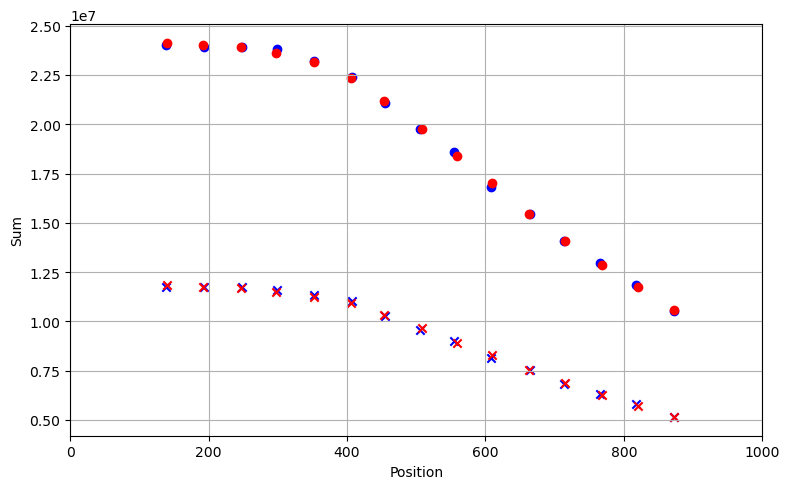

In [226]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
for i,exp_id_ in enumerate(ids):
    if i%2==0:
        color = 'b'
    else:
        color = 'r'
    ax.scatter(exp_int[exp_id_][0],exp_int[exp_id_][1],marker='o',color=color)
    ax.scatter(exp_int[exp_id_][0],exp_int[exp_id_][2],marker='x',color=color)
    
    print(i,exp_id_,exp_int[exp_id_][0],exp_int[exp_id_][1],exp_int[exp_id_][2])
ax.grid()
ax.set_xlim(0,1000)
ax.set_xlabel('Position')
ax.set_ylabel('Sum')
plt.tight_layout()